In [ ]:
pip install transformers torch pandas

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
  Using cached nvidia_nvjitlink_cu12-12.4.127-py3-none-m

In [ ]:
import pandas as pd

# Load the data
df = pd.read_csv('truncated_labeled_data.csv')

# Display the first few rows to check the data
print(df.head())

                                                text  label
0  tech company bought another company late 22 wo...      0
1  im 7 months search ive definitely seen dark ho...      0
2  httpswwwcnncom20240222techattcellserviceoutage...      0
3  program created bring experts program heavily ...      0
4  field bring joy rather immense stress cycle la...      0


In [ ]:
import re

# Simple text cleaning process
def clean_text(text):
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)  # Remove punctuation
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces, tabs, and newlines
    return text

df['text'] = df['text'].apply(clean_text)

In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import RobertaTokenizer, RobertaForSequenceClassification
import torch

# Load tokenizers and models
bert_tokenizer = BertTokenizer.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')
bert_model = BertForSequenceClassification.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')

roberta_tokenizer = RobertaTokenizer.from_pretrained('cardiffnlp/twitter-roberta-base-sentiment')
roberta_model = RobertaForSequenceClassification.from_pretrained('cardiffnlp/twitter-roberta-base-sentiment')

# Function to get sentiment with truncation for BERT
def get_sentiment_bert(text):
    inputs = bert_tokenizer(text, return_tensors="pt", truncation=True, max_length=512)
    with torch.no_grad():
        outputs = bert_model(**inputs)
    # Get the highest probability label
    label_idx = torch.argmax(outputs.logits, dim=1).item()
    labels = ['1 star', '2 stars', '3 stars', '4 stars', '5 stars']  # Modify as per model's label
    return labels[label_idx], torch.softmax(outputs.logits, dim=1).max().item()

# Function to get sentiment with truncation for RoBERTa
def get_sentiment_roberta(text):
    inputs = roberta_tokenizer(text, return_tensors="pt", truncation=True, max_length=512)
    with torch.no_grad():
        outputs = roberta_model(**inputs)
    label_idx = torch.argmax(outputs.logits, dim=1).item()
    labels = ['Negative', 'Neutral', 'Positive']  # Modify as per model's label
    return labels[label_idx], torch.softmax(outputs.logits, dim=1).max().item()


In [ ]:
# Wrapper functions to simplify calling
def apply_sentiment_bert(text):
    label, score = get_sentiment_bert(text)
    return f"{label} {score:.4f}"

def apply_sentiment_roberta(text):
    label, score = get_sentiment_roberta(text)
    return f"{label} {score:.4f}"

# Apply sentiment analysis
df['bert_sentiment'] = df['text'].apply(apply_sentiment_bert)
df['roberta_sentiment'] = df['text'].apply(apply_sentiment_roberta)

# Print results to compare
print(df[['text', 'bert_sentiment', 'roberta_sentiment']].head())

                                                text  bert_sentiment  \
0  tech company bought another company late 22 wo...   1 star 0.6640   
1  im 7 months search ive definitely seen dark ho...  4 stars 0.2237   
2  httpswwwcnncom20240222techattcellserviceoutage...   1 star 0.7114   
3  program created bring experts program heavily ...   1 star 0.6570   
4  field bring joy rather immense stress cycle la...  2 stars 0.3235   

  roberta_sentiment  
0    Neutral 0.5356  
1    Neutral 0.5542  
2   Negative 0.7474  
3   Negative 0.6290  
4   Positive 0.7533  


In [ ]:
# Print out results to compare
print(df[['text', 'bert_sentiment', 'roberta_sentiment']].head(20))


KeyError: "['bert_sentiment', 'roberta_sentiment'] not in index"

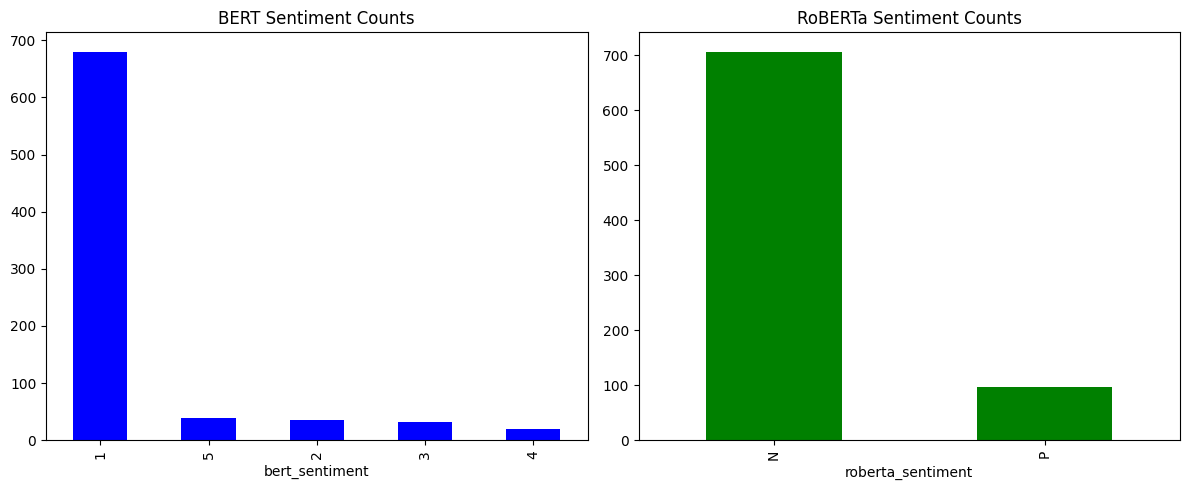

In [ ]:
import matplotlib.pyplot as plt

# Assuming we're just plotting counts of sentiment labels for comparison
sentiment_bert_counts = df['bert_sentiment'].apply(lambda x: x[0]).value_counts()
sentiment_roberta_counts = df['roberta_sentiment'].apply(lambda x: x[0]).value_counts()

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sentiment_bert_counts.plot(kind='bar', ax=axes[0], title='BERT Sentiment Counts', color='blue')
sentiment_roberta_counts.plot(kind='bar', ax=axes[1], title='RoBERTa Sentiment Counts', color='green')

plt.tight_layout()
plt.show()

In [ ]:
pip install numpy scikit-learn pandas transformers torch


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load data
df = pd.read_csv('truncated_labeled_data.csv')

# Basic preprocessing
df['text'] = df['text'].apply(lambda x: x.lower())

# Split data
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df['text'], df['label'], test_size=0.2, random_state=42
)


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=10000)
train_features = vectorizer.fit_transform(train_texts)
test_features = vectorizer.transform(test_texts)


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC

# Logistic Regression
lr_model = LogisticRegression(random_state=42)
lr_model.fit(train_features, train_labels)

# Naive Bayes
nb_model = MultinomialNB()
nb_model.fit(train_features, train_labels)

# Support Vector Machine
svm_model = SVC(random_state=42)
svm_model.fit(train_features, train_labels)


SVC(random_state=42)

In [ ]:
pip install accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.6/297.6 kB 4.0 MB/s eta 0:00:00


In [ ]:
pip install accelerate

In [ ]:
pip install --upgrade accelerate

In [ ]:
pip install transformers[torch]

In [ ]:
pip show accelerate


Name: accelerate
Version: 0.29.3
Summary: Accelerate
Home-page: https://github.com/huggingface/accelerate
Author: The HuggingFace team
Author-email: zach.mueller@huggingface.co
License: Apache
Location: /usr/local/lib/python3.10/dist-packages
Requires: huggingface-hub, numpy, packaging, psutil, pyyaml, safetensors, torch
Required-by: 


In [ ]:
import sys
print("Python EXE:", sys.executable)

import accelerate
print("Accelerate Version:", accelerate.__version__)


Python EXE: /usr/bin/python3
Accelerate Version: 0.29.3


In [ ]:
!pip install --upgrade accelerate


In [ ]:

pip install torch transformers


In [ ]:
import torch
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import numpy as np

# Load data
df = pd.read_csv('truncated_labeled_data.csv')
df['text'] = df['text'].apply(lambda x: x.lower())  # lowercasing text

# Tokenization
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
tokenized = df['text'].apply(lambda x: tokenizer.encode(x, add_special_tokens=True, max_length=512, truncation=True))

# Padding
max_len = max(map(len, tokenized))
padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized])

# Attention masks
attention_mask = np.where(padded != 0, 1, 0)

# Labels
le = LabelEncoder()
labels = le.fit_transform(df['label'])

# Dataset
input_ids = torch.tensor(padded)
attention_mask = torch.tensor(attention_mask)
labels = torch.tensor(labels)

dataset = TensorDataset(input_ids, attention_mask, labels)
train_idx, val_idx = train_test_split(range(len(labels)), test_size=0.2, random_state=42)

train_sampler = RandomSampler(train_idx)
train_dataloader = DataLoader(dataset, sampler=train_sampler, batch_size=8)

val_sampler = SequentialSampler(val_idx)
val_dataloader = DataLoader(dataset, sampler=val_sampler, batch_size=8)

# Load model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(le.classes_))

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [ ]:
from torch.optim import AdamW

optimizer = AdamW(model.parameters(), lr=2e-5)

for epoch in range(3):  # loop over the dataset multiple times
    model.train()
    for batch in train_dataloader:
        b_input_ids, b_input_mask, b_labels = tuple(t.to(device) for t in batch)
        model.zero_grad()
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        loss = outputs[0]
        loss.backward()
        optimizer.step()

    model.eval()
    eval_loss = 0
    eval_steps = 0
    for batch in val_dataloader:
        b_input_ids, b_input_mask, b_labels = tuple(t.to(device) for t in batch)
        with torch.no_grad():
            outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
            loss = outputs[0]
            eval_loss += loss.item()
            eval_steps += 1

    print(f"Epoch {epoch}, Loss: {loss.item()}, Eval Loss: {eval_loss/eval_steps}")


Epoch 0, Loss: 0.09918943047523499, Eval Loss: 0.25693842733190175
Epoch 1, Loss: 0.05370330438017845, Eval Loss: 0.20175597195823988
Epoch 2, Loss: 0.014423750340938568, Eval Loss: 0.14230127818882465


In [ ]:
from sklearn.metrics import accuracy_score

best_val_accuracy = 0.0

for epoch in range(3):  # loop over the dataset multiple times
    model.train()
    train_loss = 0
    steps = 0
    for batch in train_dataloader:
        b_input_ids, b_input_mask, b_labels = tuple(t.to(device) for t in batch)
        optimizer.zero_grad()
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        steps += 1

    avg_train_loss = train_loss / steps
    print(f"Training loss: {avg_train_loss}")

    # Validation phase
    model.eval()
    val_accuracy = []
    val_loss = 0
    for batch in val_dataloader:
        b_input_ids, b_input_mask, b_labels = tuple(t.to(device) for t in batch)
        with torch.no_grad():
            outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
            loss = outputs.loss
            logits = outputs.logits
            val_loss += loss.item()

            preds = torch.argmax(logits, dim=1).flatten()
            targets = b_labels.flatten()
            accuracy = accuracy_score(targets.cpu(), preds.cpu())
            val_accuracy.append(accuracy)

    avg_val_accuracy = sum(val_accuracy) / len(val_accuracy)
    avg_val_loss = val_loss / len(val_dataloader)
    print(f"Validation Loss: {avg_val_loss}, Validation Accuracy: {avg_val_accuracy}")

    # Save the best model
    if avg_val_accuracy > best_val_accuracy:
        best_val_accuracy = avg_val_accuracy
        model.save_pretrained('./best_model')
        tokenizer.save_pretrained('./best_model')

print("Training complete.")


Training loss: 0.15937797253790462
Validation Loss: 0.10481542224685352, Validation Accuracy: 0.9761904761904762
Training loss: 0.12775442803301562
Validation Loss: 0.09983878232361305, Validation Accuracy: 0.9642857142857143
Training loss: 0.07426510453454138
Validation Loss: 0.04080761084333062, Validation Accuracy: 0.9880952380952381
Training complete.


In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification

# Load the best model
model_path = './best_model'
model = BertForSequenceClassification.from_pretrained(model_path)
tokenizer = BertTokenizer.from_pretrained(model_path)
model.to(device)
model.eval()

# Function to make predictions
def predict(text, tokenizer, model):
    inputs = tokenizer.encode_plus(text, add_special_tokens=True, max_length=512, truncation=True, return_tensors="pt")
    inputs.to(device)
    with torch.no_grad():
        outputs = model(**inputs)
        prediction = torch.argmax(outputs.logits, dim=1).item()

    return le.inverse_transform([prediction])[0]  # Convert numerical prediction back to label

# Example usage
sample_text = "Example text that you want to classify."
predicted_label = predict(sample_text, tokenizer, model)
print("Predicted Label:", predicted_label)


Predicted Label: 0


In [ ]:
from sklearn.metrics import classification_report

# Evaluate traditional models
print("Logistic Regression:", classification_report(test_labels, lr_model.predict(test_features)))
print("Naive Bayes:", classification_report(test_labels, nb_model.predict(test_features)))
print("SVM:", classification_report(test_labels, svm_model.predict(test_features)))

# Evaluate BERT
predictions = trainer.predict(test_dataset)
print("BERT:", classification_report(test_labels, predictions.predictions.argmax(-1)))

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

Logistic Regression:               precision    recall  f1-score   support

           0       0.93      1.00      0.96       150
           1       0.00      0.00      0.00        11

    accuracy                           0.93       161
   macro avg       0.47      0.50      0.48       161
weighted avg       0.87      0.93      0.90       161

Naive Bayes:               precision    recall  f1-score   support

           0       0.93      1.00      0.96       150
           1       0.00      0.00      0.00        11

    accuracy                           0.93       161
   macro avg       0.47      0.50      0.48       161
weighted avg       0.87      0.93      0.90       161

SVM:               precision    recall  f1-score   support

           0       0.93      1.00      0.96       150
           1       0.00      0.00      0.00        11

    accuracy                           0.93       161
   macro avg       0.47      0.50      0.48       161
weighted avg       0.87      0.93  

NameError: name 'trainer' is not defined

In [ ]:
# Initialize storage for results
results = []

for epoch in range(3):  # Loop over the dataset multiple times
    model.train()
    train_loss = 0
    steps = 0
    for batch in train_dataloader:
        b_input_ids, b_input_mask, b_labels = tuple(t.to(device) for t in batch)
        optimizer.zero_grad()
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        steps += 1

    avg_train_loss = train_loss / steps
    print(f"Training loss: {avg_train_loss}")

    # Validation phase
    model.eval()
    val_accuracy = []
    val_loss = 0
    for batch in val_dataloader:
        b_input_ids, b_input_mask, b_labels = tuple(t.to(device) for t in batch)
        with torch.no_grad():
            outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
            loss = outputs.loss
            logits = outputs.logits
            val_loss += loss.item()

            preds = torch.argmax(logits, dim=1).flatten()
            targets = b_labels.flatten()
            accuracy = accuracy_score(targets.cpu(), preds.cpu())
            val_accuracy.append(accuracy)

    avg_val_accuracy = sum(val_accuracy) / len(val_accuracy)
    avg_val_loss = val_loss / len(val_dataloader)
    print(f"Validation Loss: {avg_val_loss}, Validation Accuracy: {avg_val_accuracy}")

    # Save results
    results.append({
        'epoch': epoch,
        'train_loss': avg_train_loss,
        'val_loss': avg_val_loss,
        'val_accuracy': avg_val_accuracy
    })

Training loss: 0.032013088576840584
Validation Loss: 0.04080761084333062, Validation Accuracy: 0.9880952380952381
Training loss: 0.03113025556502427
Validation Loss: 0.04080761084333062, Validation Accuracy: 0.9880952380952381
Training loss: 0.03788278157029439
Validation Loss: 0.04080761084333062, Validation Accuracy: 0.9880952380952381


In [ ]:
# Print results in a tabulated format
for result in results:
    print(f"Epoch {result['epoch']}: Train Loss = {result['train_loss']:.4f}, "
          f"Validation Loss = {result['val_loss']:.4f}, Validation Accuracy = {result['val_accuracy']:.4%}")


Epoch 0: Train Loss = 0.0320, Validation Loss = 0.0408, Validation Accuracy = 98.8095%
Epoch 1: Train Loss = 0.0311, Validation Loss = 0.0408, Validation Accuracy = 98.8095%
Epoch 2: Train Loss = 0.0379, Validation Loss = 0.0408, Validation Accuracy = 98.8095%


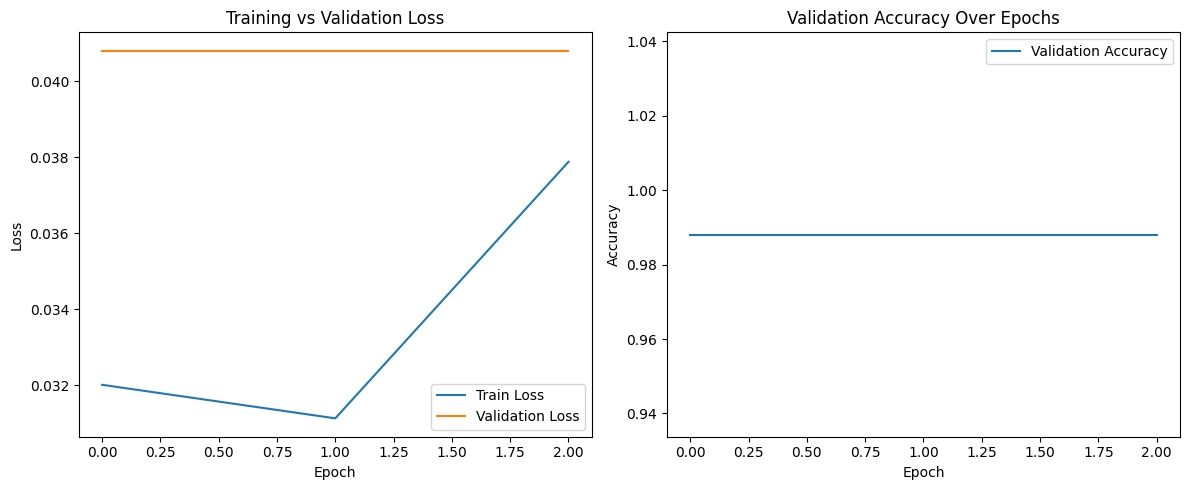

In [ ]:
import matplotlib.pyplot as plt

# Plotting training and validation losses
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot([r['epoch'] for r in results], [r['train_loss'] for r in results], label='Train Loss')
plt.plot([r['epoch'] for r in results], [r['val_loss'] for r in results], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()

# Plotting validation accuracy
plt.subplot(1, 2, 2)
plt.plot([r['epoch'] for r in results], [r['val_accuracy'] for r in results], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()
